# Statistical Tests Decision Tree

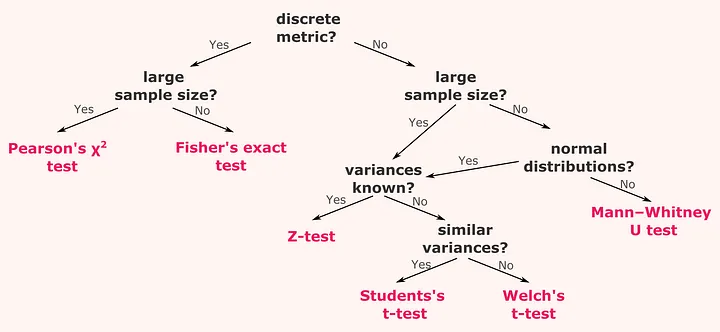

Casalegno, F. 2021. A/B Testing: A Complete Guide to Statistical Testing. Towards Data Science. https://towardsdatascience.com/a-b-testing-a-complete-guide-to-statistical-testing-e3f1db140499


# Libraries & Dependencies

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.special import binom
from scipy.stats import chi2_contingency, mannwhitneyu, norm, t, ttest_ind,norm,hypergeom

# Data

In [14]:
raw_data = pd.read_csv('D7 Retention Data.csv')
df = raw_data.fillna(0)
df

,User Pseudo Id (index),Test Group,Retention D7
0,1,1,0.0
1,2,1,0.0
2,3,1,0.0
3,4,1,0.0
4,5,1,0.0
...,...,...,...
57280,57281,0,0.0
57281,57282,1,0.0
57282,57283,1,0.0
57283,57284,0,0.0


## AB Retention Rates

In [15]:
retention_df = df.groupby(['Test Group'], as_index=False).agg(
                                                Retained_Users = ('Retention D7', 'sum'),
                                                Users = ('Retention D7', 'count') 
                                              )

retention_df['D7'] = retention_df['Retained_Users'] / retention_df['Users']
retention_df

,Test Group,Retained_Users,Users,D7
0,0,1291.0,28710,0.044967
1,1,1420.0,28575,0.049694


## Sample Size 

In [19]:
def required_sample_size_ztest(alpha=0.05, power=0.8, prop0=0.5, prop1=0.6):
    """
    Calculate the required sample size for a two-proportions z-test.

    Parameters:
    - alpha: significance level
    - power: desired power of the test
    - prop0: proportion in base 
    - prop1: proportion in variant 

    Returns:
    - Sample size required for each group.
    """
    pooled_prop = (prop0 + prop1) / 2
    pooled_se = math.sqrt(2 * pooled_prop * (1 - pooled_prop))  # Pooled standard error for equal sample sizes

    # Z-scores for alpha and power
    z_alpha = norm.ppf(1 - alpha / 2)
    z_power = norm.ppf(power)

    effect_size = abs(prop0 - prop1)
    
    # Calculating required sample size for each group
    n = ((z_alpha + z_power) * pooled_se / effect_size) ** 2

    return n

# Example usage:
alpha = 0.05
power = 0.8
prop0 = 0.044967
prop1 = 0.049694

sample_size = required_sample_size_ztest(alpha, power, prop0, prop1)
print(f"Required sample size per group: {sample_size:.0f}")

Required sample size per group: 31677


## Contingency  table

In [24]:
retention_df['Non_Retained_Users'] = retention_df['Users'] - retention_df['Retained_Users']
retention_df

,Test Group,Retained_Users,Users,Non_Retained_Users,D7
0,0,1291.0,28710,27419.0,0.044967
1,1,1420.0,28575,27155.0,0.049694


In [58]:
# Creating a D7 contingency table
contingency_table = retention_df.pivot_table(values=['Retained_Users', 'Non_Retained_Users'], 
                                             index='Test Group', 
                                             aggfunc='sum').T

contingency_table

Test Group,0,1
Non_Retained_Users,27419.0,27155.0
Retained_Users,1291.0,1420.0


# Fisher's exact test - Sample Size is small

Fisher's Exact Test: 

It is based on the hypergeometric distribution. 

The test calculates the exact probability of observing the given distribution of frequencies, given the marginal totals of the table.

In [61]:
def fisher_exact_test(contingency_input):
    """
    Compute the p-value for the given contingency table using Fisher's exact test.

    Parameters:
    - contingency_input: 2x2 Pandas DataFrame or numpy array
    
    Returns:
    - p-value
    """
    
    # Convert DataFrame to numpy array if necessary
    contingency_table = np.array(contingency_input) if isinstance(contingency_input, pd.DataFrame) else contingency_input
    
    # Extract individual cell counts
    a, b, c, d = contingency_table.flatten()

    # Calculate parameters for the hypergeometric distribution
    M = a + b + c + d  # Total number of items
    n = a + b          # Total successes in the population
    N = a + c          # Total draws

    # Calculate the probability of getting a success
    p_value = hypergeom.sf(a-1, M, n, N)
    
    return p_value

# Example usage:

p_val = fisher_exact_test(contingency_table)
print(f"Fisher's exact test: p-val = {100*p_val:.1f}%")


Fisher's exact test: p-val = 0.4%


# Pearson's chi-squared test - Sample size is large

Pearson's Chi-Squared Test: 

It uses the chi-squared distribution to approximate the distribution of the test statistic under the null hypothesis. 

The test determines how much the observed frequencies deviate from frequencies that would be expected under the null hypothesis of no association.

In [64]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

def chi_squared_test(contingency_input):
    """
    Compute the chi-squared statistic and p-value for the given contingency table using Pearson's chi-squared test.

    Parameters:
    - contingency_input: 2x2 Pandas DataFrame or numpy array
    
    Returns:
    - chi2_statistic, p-value
    """
    
    # Convert DataFrame to numpy array if necessary
    contingency_table = np.array(contingency_input) if isinstance(contingency_input, pd.DataFrame) else contingency_input
    
    # Compute chi-squared statistic and p-value
    chi2_statistic, p_value, _, _ = chi2_contingency(contingency_table)
    
    return chi2_statistic, p_value

# Example usage:

chi2_stat, p_val = chi_squared_test(contingency_table)
print(f"Pearson's chi-squared test: p-val = {p_val:.4f}")


Pearson's chi-squared test: p-val = 0.0082


# Conclusions

While both tests examine the independence of two categorical variables, they do so using different probability models:

Fisher's exact test directly calculates the probability of obtaining the observed distribution of frequencies (and more extreme distributions), given the fixed marginal totals, using the hypergeometric distribution.

Pearson's chi-squared test looks at the divergence of the observed frequencies from expected frequencies under the null hypothesis of no association, using the chi-squared distribution as an approximation.

For many practical applications, especially with large samples, the two tests will often lead to similar conclusions. However, their differences become more noticeable with smaller samples or when expected cell counts are low.